In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *


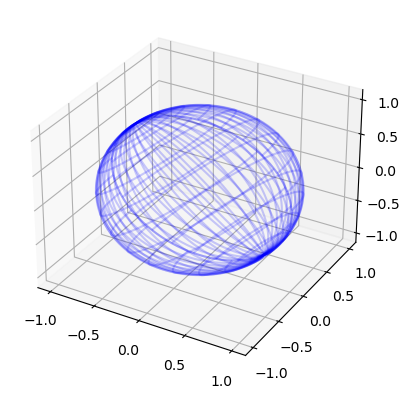

0.0


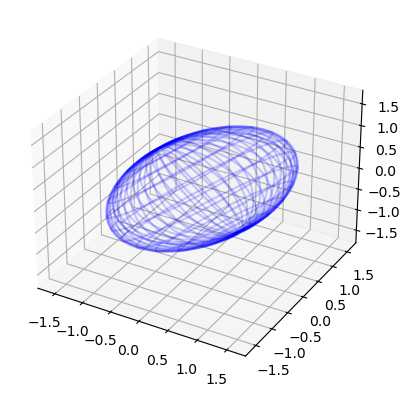

0.408248290463863


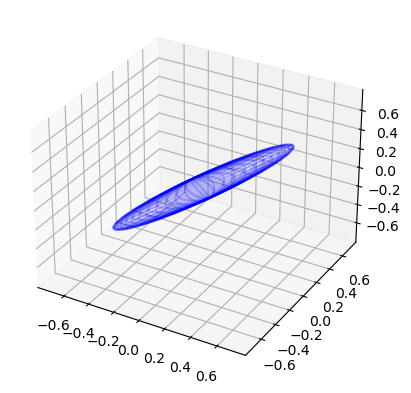

0.8911327886790067


In [2]:
abc1 = [1,1,1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc1,thetaxyz1)
# plot
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA0.png',format='png',dpi=120)

pl.show()
print(Calc_FA(abc1[0],abc1[1],abc1[2]))

abc2 = [1,2,1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc2,thetaxyz1)
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
pl.show()
print(Calc_FA(abc2[0],abc2[1],abc2[2]))


abc3 = [1,.1,.1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc3,thetaxyz1)
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA89.png',format='png',dpi=120)
pl.show()
print(Calc_FA(abc3[0],abc3[1],abc3[2]))



# Esimation of FA
FA seems to be from about 0.1 to .4

conventional FA (0.19 ± 0.02 and 0.40 ± 0.02) 

https://pubmed.ncbi.nlm.nih.gov/31243814/


combined IVIm and DTI for directionality

https://pubmed.ncbi.nlm.nih.gov/24752998/ Table 2!

## in tissue component:

FA D_tissue cortex = 0.18, medullar = 0.38


## in perfusion component:
FA D_perfusion cortex = 0.09, medullar = 0.41

## in tubular component
guess: tubular would be in between?


# To Do: 

- [x] So given an FA, be able to write up an ellipsoid that has that FA. 

- [x] Assume a tri-component model, give those three components three different FAs

- [x] Build the tri-exponential model (i.e. fraction and TRACE diffusion coefficient)

- [x] Trace is average of the three assumed orthogonal vectors. 

- [x] so for ax, by, cz as the ellipsoid coefficients.... (aDx + bDy + cDz)/3 = D_tr. 

- [x] Think can just be scaling by the radius of a direction... 

- [x] Then for every individual b-value (b_n), rotate ellipsoid and selected the D that would be measured along that direction. 

- [x] Assign that D_n to the given b_n. 

- [x] Plot D_n as a function of b_n 

fit the curve, and see how close it is to true tri-exponential.

# creating ellipsoids given an FA

In [3]:
def Calc_FA(a,b,c):
    MD = (a+b+c)/3
    num = np.sqrt((a-MD)**2 + (b-MD)**2 + (c-MD)**2)
    denom = np.sqrt(a**2 + b**2 + c**2)
    return np.sqrt(3/2)*num/denom

# first setting up FA to produce ellipsoid
FAs = np.zeros(100)
abcs = np.empty([100,3])
for j in range(1,100):
    abc3 = [1,random.uniform(0.01,1),random.uniform(0.01,1)]
    #print(abc3)
    FAs[j] = (Calc_FA(abc3[0],abc3[1],abc3[2]))
    abcs[j,:] = abc3
    
#idx = np.argsort(FAs)
#FAs = np.array(FAs)[idx]
#abcs = np.array(abcs)[idx]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def GenerateFA_Ellipsoid(FA_want,FAs,abcs):
    val,idx = find_nearest(FAs,FA_want)
    return abcs[idx]#, FA(abcs[idx][0],abcs[idx][1],abcs[idx][2])
    

In [4]:
abc_test = GenerateFA_Ellipsoid(.5,FAs,abcs)

# Creating triexp model following Gladytz model

In [5]:
#Diffusion Parameters (Baseline)
diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60

#hypothetical for the moment
b_values9 = np.array([0,10,30,50,80,120,200,400,800])
b_values = np.array([0,10,30,50,80,120,200,300,400,600,800,1000,1500])

def triexp_func(b, frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow):
    return (1-frac_med-frac_fast)*np.exp(-b*diff_slow)+frac_med*np.exp(-b*diff_med)+frac_fast*np.exp(-b*diff_fast)
    
SI = triexp_func(b_values,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
SI_9  = triexp_func(b_values9,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
## can also add noise eventually, but not right now?
# or try adding rician from old code


In [6]:
def NoiseRice(I,sigma): # noise with rician distribution
    N = [] 
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise measured!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N

In [7]:
SI_noise = NoiseRice(SI, .02) # with SNR = 50

SI_noise9 = NoiseRice(SI_9, .02) # with SNR = 50

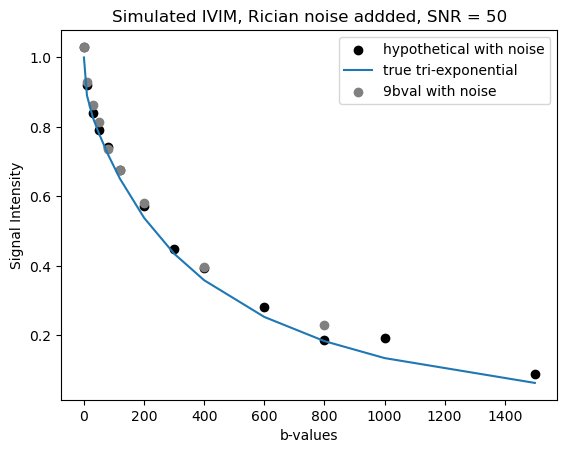

In [8]:
pl.scatter(b_values,SI_noise,color = 'black', label = 'hypothetical with noise')
pl.plot(b_values,SI,label = 'true tri-exponential')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')

pl.scatter(b_values9,SI_noise9,color = 'gray', label = '9bval with noise')
pl.legend()
pl.show()

# Calculation of effect of measuring only one direction
So this is 13 b-values 

say the first 6 are fast component (up to 120)

the next four are mid component (up to 600)

the last three are slow component (800 to 1500)

- first six get 6 different directions of rotation 
- next four get 4 different directions of rotation 
- last 3 get three different directions

so now from each individual point, I need to add or subtract the difference that using one direction randomly chosen would give.

for example, for b = 100, the point is $frac_{fast}e^{(-100*D_tr)}$
I need to make it now $frac_{fast}exp{(-100*D_{\theta_1})}$ where $rot1$ is one direction rotated by some angle. I need to calculate $D_{\theta_n}$ for every $b_n$.

With the ellipsoid, essentially Eq. 1
$$D_{tr} =  \frac{(Dxx +Dyy + Dzz)}{3} = \frac{A_xD + B_yD + C_zD}{3}$$

Where $A_x$, $B_y$, and $C_z$ are the scaled ellipsoid eigenvectors.

So, for a given $\theta_n$, we know $D_tr = D_fast$ (or slow or med). We know the assumed fractional anisotropy, i.e. $A_x$, $B_y$, and $C_z$. Therefore we solve for D in Eq. 1 and we get $D_{\theta_n}$ by rotating the ellipsoid by $\theta_n$, measuring the x-axis in the rotated frame $x_\theta$ (assumed for this, can choose any of the 3 as long as it's consistent across all $\theta_n$s), and then multiplying by D. This $x_{\theta}D = D_{\theta_n}$


In [9]:
def Scale_Ds(D_traces,abc_s,thetas):
    D_thetas = np.zeros(len(D_traces))
    for n in range(len(D_traces)): #here n is fast, medium, or slow compartments. i.e. the 3 ellipsoids
        D_n = 3*D_traces[n]/sum(abc_s[n]) #normalize to ellipsoid (basically normalize to 1)
        D_thetas[n] = D_n*thetas[n] #multiply by diffusion strength along b-value direction 
    return D_thetas



#create an ellipsoid with a given FA
#rotate it within the lab frame (i.e. slow compartment is tilted k-degrees in lab frame while fast compartment is tilted h-degrees in lab frame)
def generate_rotated_anisotropic_ellipsoid(FA,compartment_rotations):
    # FAs and abcs are just previously generated potentials to choose from
    FAs = np.zeros(100)
    abcs = np.empty([100,3])
    for j in range(1,100): #creating an elipsoid
        abc3 = [1,random.uniform(0.01,1),random.uniform(0.01,1)]
        #print(abc3)
        FAs[j] = (Calc_FA(abc3[0],abc3[1],abc3[2]))
        abcs[j,:] = abc3
    abc = GenerateFA_Ellipsoid(FA,FAs,abcs) #getting the ellipsoidal dimensions
    a = abc[0] # i.e. Ax
    b = abc[1] # i.e. By
    c = abc[2] # i.e. Cz
    #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    
    #rotate by compartment_dependent lab-frame angles
    rotation = Rxyz(compartment_rotations)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    return x,y,z,abc


#give all fractional anisotropies and their lab-frame rotations to generate the three compartment ellipsoids up front
def CreateThreeEllipsoidalCompartments(All_FAs, All_rotations):
    FA_fast, FA_med, FA_slow = All_FAs[0],All_FAs[1], All_FAs[2] # the anisotropies
    fastrot,medrot,slowrot = All_rotations[0], All_rotations[1], All_rotations[2] #the original ellipsoid rotations (in the lab frame, so not all aligned in same direction)
    
    #create the three compartment ellipsoids rotate din lab-space, and then rotate along the b-value direction
    x_fast,y_fast,z_fast,abc_fast = generate_rotated_anisotropic_ellipsoid(FA_fast,fastrot) # but then thetaxyz are same for fast, med, slow, because it's measured in the same lab-frame direction
    x_med,y_med,z_med,abc_med = generate_rotated_anisotropic_ellipsoid(FA_med,medrot)
    x_slow,y_slow,z_slow,abc_slow = generate_rotated_anisotropic_ellipsoid(FA_slow,slowrot)
    
    fast_compartment = [x_slow,y_slow,z_slow,abc_fast]
    med_compartment = [x_med,y_med,z_med,abc_med]
    slow_compartment = [x_slow,y_slow,z_slow,abc_slow]
    return fast_compartment, med_compartment, slow_compartment

def RotateCompartments(x,y,z,thetaxyz):
    center = [0,0,0]
    rotation = Rxyz(thetaxyz)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    return x,y,z

#give true D, the three ellipsoidal compartments in labframe, and the b-value direction (i.e. thetaxyz)
def GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz):
    
    #now "measured along 3 orthogonal diffusion directions" to get 3 single-direction b-values
    #rotate by thetaxyz
    x_fast,y_fast,z_fast = RotateCompartments(fast_compartment[0],fast_compartment[1],fast_compartment[2],thetaxyz)
    x_med,y_med,z_med = RotateCompartments(med_compartment[0],med_compartment[1],med_compartment[2],thetaxyz)
    x_slow,y_slow,z_slow = RotateCompartments(slow_compartment[0],slow_compartment[1],slow_compartment[2],thetaxyz)

    #now measure along the given b-value direction
    x_theta_fast,y_theta_fast,z_theta_fast = find_axes(x_fast,y_fast,z_fast) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_med,y_theta_med,z_theta_med = find_axes(x_med,y_med,z_med) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_slow,y_theta_slow,z_theta_slow = find_axes(x_slow,y_slow,z_slow) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)

    #now assume the single direction is measured along the x-axis (just so it's one direction)
    x_thetas = [x_theta_fast, x_theta_med, x_theta_slow]
    abc_s = [fast_compartment[3],med_compartment[3],slow_compartment[3]]
    #get the new "diffusion values" i.e. the AxD_slow, AxD_med, AxD_fast
    D_traces_b = Scale_Ds(D_traces,abc_s,x_thetas) 
    
    return D_traces_b

    

In [18]:
# set the 3 ellipsoids

#  the fast component, estimate FA ~ .12
#  the middle component, estimate FA ~ .2
#  the slow component, estimate FA ~ .3
est_FAS = [.12,.2,.3]
D_traces = [diff_fast,diff_med, diff_slow]

# assume 3 random sets of orientations for fast, middle, and slow compartments
fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

assumed_rots = [fast_rot, med_rot, slow_rot]
print(assumed_rots)
#b0 is D_tr (no directionality) 
# have 12 b values, (13 w b0) so need 12 different rotations.
n = 12
thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

# generate the 3 ellipsoids: 
fast_compartment, med_compartment, slow_compartment = CreateThreeEllipsoidalCompartments(est_FAS,assumed_rots)

D_fasts = []
D_meds = []
D_slows = []
for i in range(n):
    # for ith rotation i.e. ith b-val
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    print(thetaxyz)
    D_traces_fast, D_traces_med, D_traces_slow = GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz)
    D_fasts.append(D_traces_fast)
    D_meds.append(D_traces_med)
    D_slows.append(D_traces_slow)
    

[array([5.92566592, 0.14620483, 2.42567151]), array([2.79408388, 3.08251374, 2.2157802 ]), array([4.26996784, 5.45714094, 5.17511771])]
[4.050835748152871, 6.005523802111274, 4.491477630805124]
[0.892803716179608, 1.2087564611167791, 2.2706135146674997]
[4.6294778902738045, 4.929066995822785, 4.45012158284704]
[0.849369536654672, 4.532481062129894, 5.042708137510745]
[5.273292421084999, 2.064112782493263, 0.5508042317503095]
[6.089108136017053, 1.6490330086594296, 5.610268019308866]
[5.407475045917172, 0.662871890952813, 1.197900867527306]
[4.598159604389028, 1.325988068850638, 1.0745109256669731]
[2.102977248383038, 3.2726637160119236, 0.4742274826265424]
[2.8330672018952834, 5.890494971943302, 0.9146495849882423]
[5.67657554763888, 1.931709216747485, 5.028415781799787]
[0.5591167186558612, 3.8354374205618895, 2.7518433899103227]


In [19]:

SI_est = np.zeros(len(b_values))
SI_est[0] = triexp_func(0,frac_fast,frac_med,frac_slow,diff_fast,diff_med,diff_slow)
for k in range(1,len(b_values)): # for all of the 12 b-values
    j = k-1
    Est_signal = triexp_func(b_values[j],frac_fast,frac_med,frac_slow, D_fasts[j], D_meds[j], D_slows[j])
    SI_est[k] = Est_signal


In [20]:
# now add noise
SI_est_noise = NoiseRice(SI_est, .02) # with SNR = 50

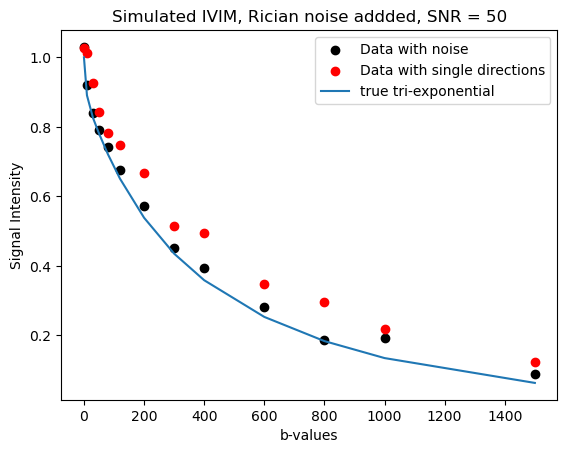

In [21]:
pl.scatter(b_values,SI_noise,color = 'black', label = 'Data with noise')
pl.scatter(b_values,SI_est_noise,color = 'red', label = 'Data with single directions')

pl.plot(b_values,SI,label = 'true tri-exponential')
pl.title('Simulated IVIM, Rician noise addded, SNR = 50')
pl.xlabel('b-values')
pl.ylabel('Signal Intensity')
pl.legend()
pl.show()


# Now need to fit it and see how much worse it is compared to truth.


Use matlab multi-exp?

https://www.mathworks.com/help/matlab/matlab_external/call-user-script-and-function-from-python.html

In [22]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.RunNNLS_ML_kidneySimulation(nargout=5)

ModuleNotFoundError: No module named 'matlab'

# and try if 2 directions rather than 1 direction also improves it
